In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import joblib

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("/kaggle/input/house-price-tehran-iran/housePrice.csv")
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [5]:
# Removing "Price(USD) column" as it is not that much helpful in this case.

df.drop("Price(USD)", axis=1, inplace=True)

In [14]:
df.sample(5)

,Area,Room,Parking,Warehouse,Elevator,Address,Price
3162,71,1,True,True,True,Shahran,2.300000e+09
239,160,3,True,True,True,Gheitarieh,1.510000e+10
2570,79,2,True,True,True,Persian Gulf Martyrs Lake,2.500000e+09
3169,81,2,True,True,True,West Ferdows Boulevard,3.400000e+09
1237,160,3,True,True,True,Saadat Abad,1.350000e+10


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3479 non-null   object 
 1   Room       3479 non-null   int64  
 2   Parking    3479 non-null   bool   
 3   Warehouse  3479 non-null   bool   
 4   Elevator   3479 non-null   bool   
 5   Address    3456 non-null   object 
 6   Price      3479 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 119.0+ KB


In [6]:
# Preprocessing on "Area" column as it should not be in object data type.

df["Area"] = df["Area"].replace(",", "", regex=True).astype("int64")

In [20]:
df.describe()

,Area,Room,Price
count,3.479000e+03,3479.000000,3.479000e+03
mean,8.744000e+06,2.079908,5.359023e+09
std,3.167266e+08,0.758275,8.099935e+09
min,3.000000e+01,0.000000,3.600000e+06
25%,6.900000e+01,2.000000,1.418250e+09
50%,9.000000e+01,2.000000,2.900000e+09
75%,1.200000e+02,2.000000,6.000000e+09
max,1.616000e+10,5.000000,9.240000e+10


In [22]:
df.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address      23
Price         0
dtype: int64

In [7]:
# Removing null records

df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3456 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3456 non-null   int64  
 1   Room       3456 non-null   int64  
 2   Parking    3456 non-null   bool   
 3   Warehouse  3456 non-null   bool   
 4   Elevator   3456 non-null   bool   
 5   Address    3456 non-null   object 
 6   Price      3456 non-null   float64
dtypes: bool(3), float64(1), int64(2), object(1)
memory usage: 145.1+ KB


In [30]:
df.groupby("Room")["Price"].mean()

Room
0    7.860500e+09
1    1.707481e+09
2    3.330303e+09
3    1.093869e+10
4    2.560033e+10
5    3.373439e+10
Name: Price, dtype: float64

In [31]:
df.groupby("Warehouse")["Price"].mean()

Warehouse
False    2.475303e+09
True     5.650029e+09
Name: Price, dtype: float64

In [32]:
df.groupby("Elevator")["Price"].mean()

Elevator
False    3.640485e+09
True     5.849825e+09
Name: Price, dtype: float64

In [34]:
pd.crosstab(df["Room"], df["Parking"])

Parking,False,True
Room,,
0,8,2
1,243,426
2,244,1699
3,26,705
4,1,69
5,5,28


In [35]:
# Number of unique records for "Address" column

df["Address"].nunique()

192

In [40]:
address_sorted = sorted(df["Address"].unique())

In [43]:
# Assessing skewness of data

df.skew(axis=0, numeric_only=True)

Area         43.827765
Room          0.623938
Parking      -1.934179
Warehouse    -2.975864
Elevator     -1.404947
Price         4.765172
dtype: float64

<Figure size 800x500 with 0 Axes>

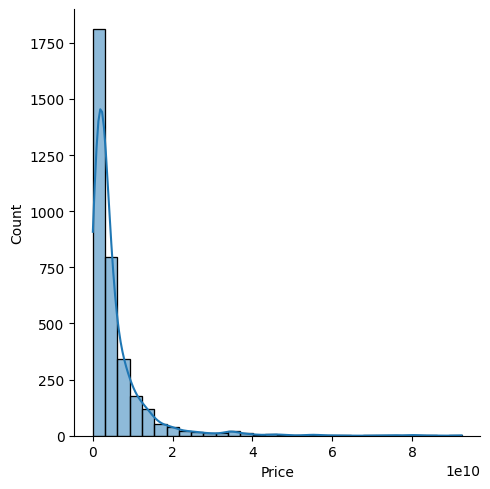

In [52]:
plt.figure(figsize=(8,5))
sns.displot(df['Price'] , bins=30 , kde=True );

<Figure size 800x500 with 0 Axes>

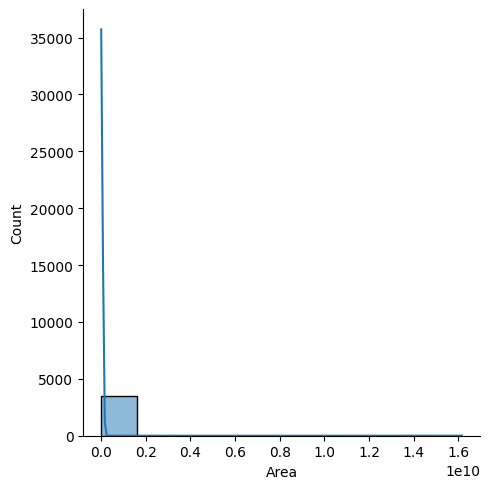

In [53]:
plt.figure(figsize=(8,5))
sns.displot(df["Area"] , bins=10 , kde=True );

<Axes: xlabel='Price'>

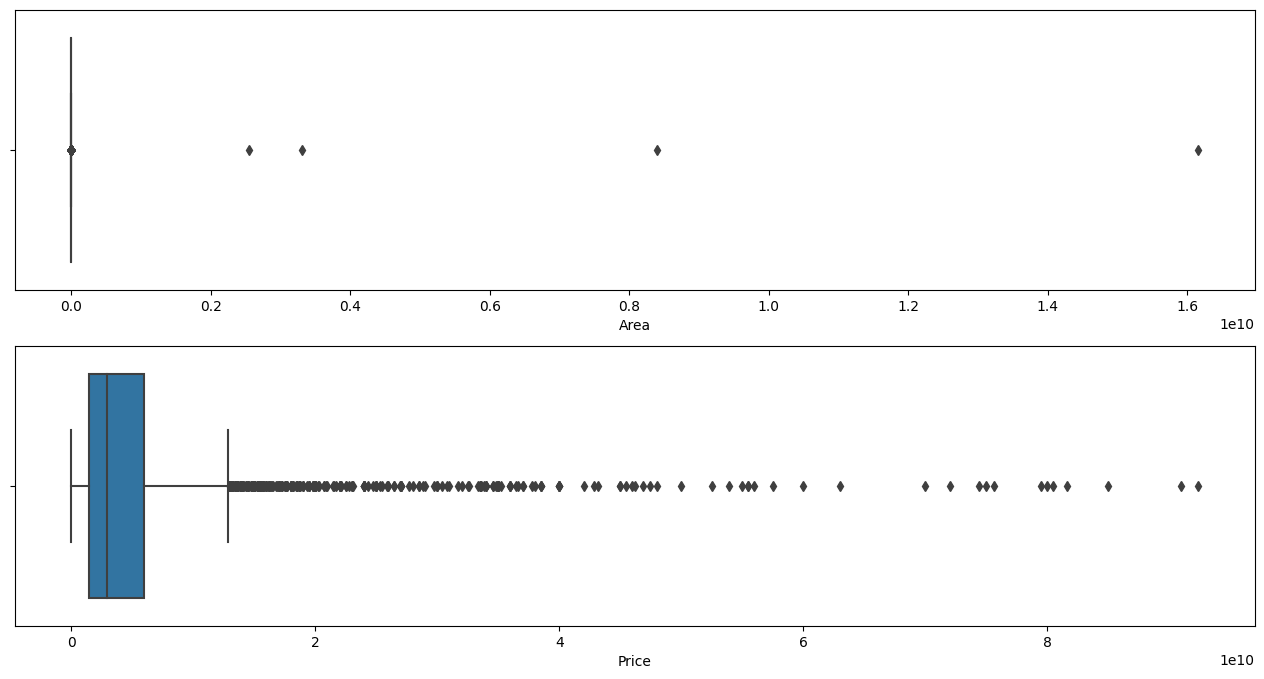

In [72]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = df['Area'])

plt.subplot(2,1,2)
sns.boxplot(x = df['Price'])

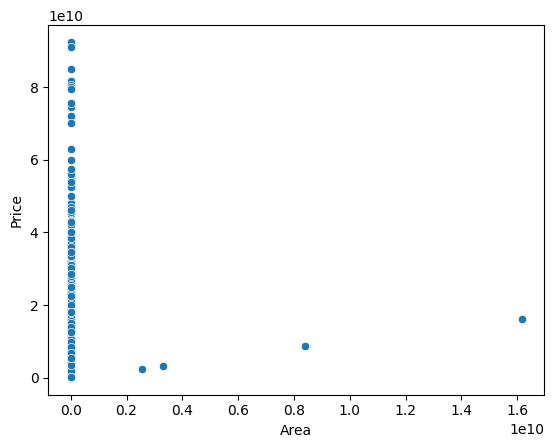

In [51]:
sns.scatterplot(x=df["Area"], y=df["Price"]);

In Area and Price columns we have skewed data. First step is to handle outliers.

In [8]:
# Handling outliers

def lower_upper(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

lower_area, upper_area = lower_upper(df['Area'])
lower_price, upper_price = lower_upper(df['Price'])

print(f"Lower limit for area: {lower_area:0.2f}")
print(f"Upper limit for area: {upper_area:0.2f}")
print(f"Lower limit for price: {lower_price:,}")
print(f"Upper limit for price: {upper_price:,}")

Lower limit for area: -9.00
Upper limit for area: 199.00
Lower limit for price: -5,450,000,000.0
Upper limit for price: 12,870,000,000.0


In [10]:
area_outliers = np.where(df['Area'] > upper_area)
price_outliers = np.where(df['Price'] > upper_price)
# Return the unique, sorted array of values that are in either of the two input arrays.
total_outliers = np.union1d(area_outliers, price_outliers)

print(f"data frame shape before outlier removal: {df.shape}")
print(f"Number of area outliers: {len(df.iloc[area_outliers])}")
print(f"Number of price outliers: {len(df.iloc[price_outliers])}")
print(f"Number of outliers: {len(df.iloc[total_outliers])}")

data frame shape before outlier removal: (3456, 7)
Number of area outliers: 237
Number of price outliers: 310
Number of outliers: 366


In [11]:
df_cleaned = df.drop(df.index[total_outliers])
print(f"data frame shape after outlier removal: {df_cleaned.shape}")

data frame shape after outlier removal: (3090, 7)


In [70]:
df_cleaned.skew(axis=0, numeric_only=True)

Area         0.679207
Room         0.170553
Parking     -1.799139
Warehouse   -2.902373
Elevator    -1.391291
Price        1.285337
dtype: float64

<Axes: xlabel='Price'>

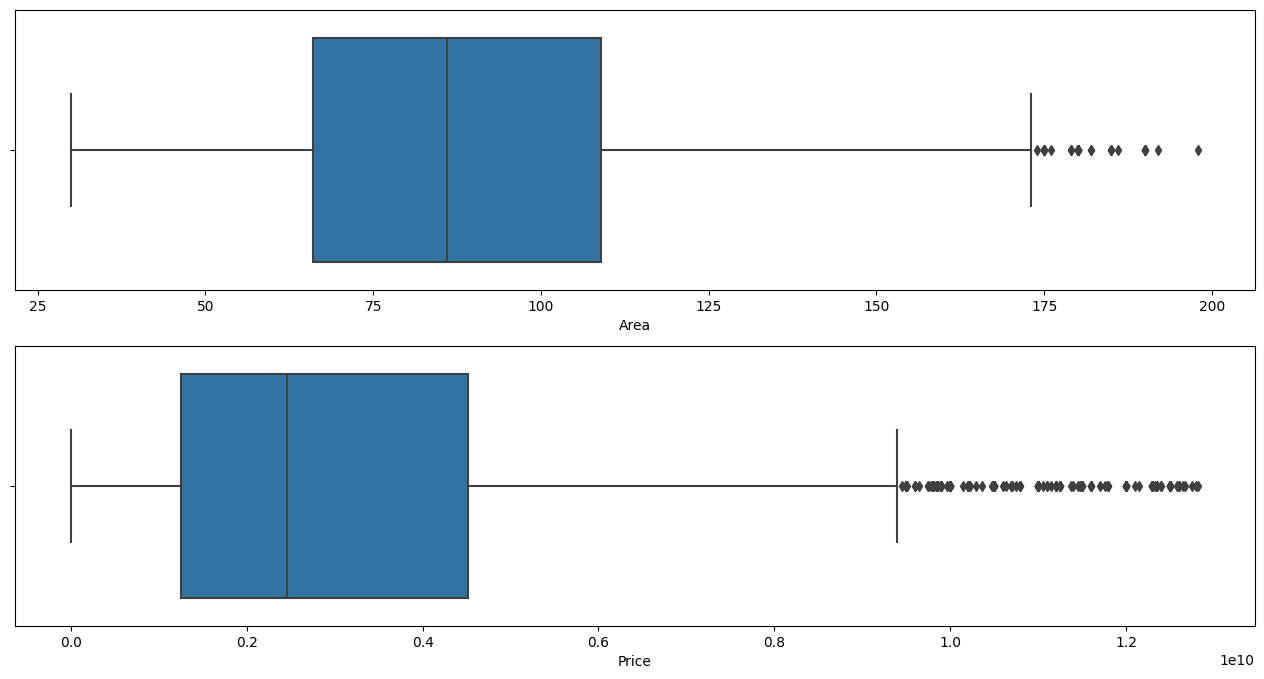

In [71]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = df_cleaned['Area'])

plt.subplot(2,1,2)
sns.boxplot(x = df_cleaned['Price'])

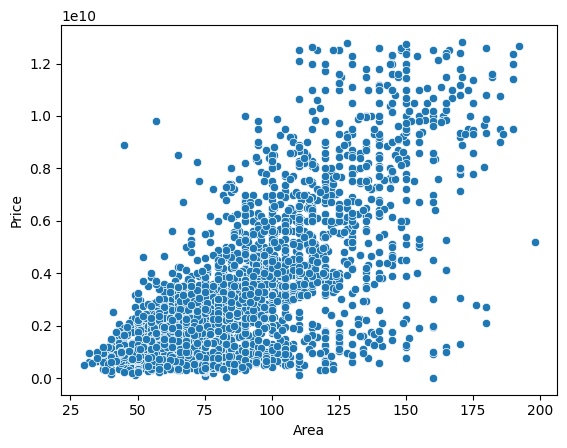

In [73]:
sns.scatterplot(x=df_cleaned["Area"], y=df_cleaned["Price"]);

According to the above result, already we successfully handled skewness of data, hence, further work, like log transformation, is not required.

In the following steps, with the help of GridSearchCV, I am going to use XGBoost, catboost, and lightgbm algorithms to find the best model and its hyperparameter.
Note: Since these three aforesaid models will be used, encoding object data type ("Address" feature) or scaling numerical data ("Area" feature) is not required.

In [12]:
df_cleaned['Address'] = df_cleaned['Address'].astype('category')

X = df_cleaned.drop(columns = 'Price')
y = df_cleaned['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"shape of x train: {X_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {X_test.shape}")
print(f"shape of y train: {y_test.shape}")

shape of x train: (2472, 6)
shape of y train: (2472,)
shape of x test: (618, 6)
shape of y train: (618,)


In [93]:
def parameter_finder (model, parameters):
    
    start = time.time()
    
    grid = GridSearchCV(model, 
                        param_grid = parameters, 
                        refit = True, 
                        cv = KFold(shuffle = True, random_state = 1), 
                        n_jobs = -1)
    grid_fit = grid.fit(X_train, y_train)
    y_train_pred = grid_fit.predict(X_train)
    y_pred = grid_fit.predict(X_test)
    
    train_score =grid_fit.score(X_train, y_train)
    test_score = grid_fit.score(X_test, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    model_name = str(model).split('(')[0]
    
    end = time.time()
    
    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")
    
       
    return train_score, test_score, RMSE

In [94]:
# Trying XGBoost

xgboost = XGBRegressor(n_jobs=-1, enable_categorical=True)

xgboost_params = {'n_estimators': [100, 200, 300],
             'learning_rate': [0.05, 0.1],
             'subsample': [0.65, 0.7, 0.75],
             'colsample_bytree': [0.65, 0.7, 0.75],
             'max_depth': [3, 5, 7, 9]}

xgboost_train_score, xgboost_test_score, xgboost_RMSE = parameter_finder(xgboost, xgboost_params)

The best parameters for XGBRegressor model is: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.75}
--------------------
(R2 score) in the training set is 92.29% for XGBRegressor model.
(R2 score) in the testing set is 87.22% for XGBRegressor model.
RMSE is 1,040,578,619.5024775 for XGBRegressor model.
--------------------
Runtime of the program is: 137.37


In [99]:
# Trying LightGBM

lightgbm = LGBMRegressor(verbose=-1)

lightgbm_params = {'n_estimators': [100, 200, 300],
                  'learning_rate': [0.05, 0.1],
                  'subsample': [0.65, 0.7, 0.75],
                  'colsample_bytree': [0.65, 0.7, 0.75],
                  'max_depth': [3, 5, 7, 9]}

lightgbm_train_score, lightgbm_test_score, lightgbm_RMSE = parameter_finder(lightgbm, lightgbm_params)

The best parameters for LGBMRegressor model is: {'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.65}
--------------------
(R2 score) in the training set is 87.79% for LGBMRegressor model.
(R2 score) in the testing set is 81.08% for LGBMRegressor model.
RMSE is 1,265,979,479.9562724 for LGBMRegressor model.
--------------------
Runtime of the program is: 98.01


In [103]:
# Trying CatBoost

catboost = CatBoostRegressor(verbose=False, cat_features=['Address'])

catboost_params = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.65, 0.7, 0.75],
    'colsample_bylevel': [0.65, 0.7, 0.75],
    'depth': [3, 5, 7, 9]
}

catboost_train_score, catboost_test_score, catboost_RMSE = parameter_finder(catboost, catboost_params)

The best parameters for <catboost.core.CatBoostRegressor object at 0x78694df77790> model is: {'colsample_bylevel': 0.65, 'depth': 7, 'iterations': 300, 'learning_rate': 0.05, 'subsample': 0.65}
--------------------
(R2 score) in the training set is 89.08% for <catboost.core.CatBoostRegressor object at 0x78694df77790> model.
(R2 score) in the testing set is 83.81% for <catboost.core.CatBoostRegressor object at 0x78694df77790> model.
RMSE is 1,170,885,923.913061 for <catboost.core.CatBoostRegressor object at 0x78694df77790> model.
--------------------
Runtime of the program is: 423.22


Based on the results of these three models, XGBRegressor outperformed the rest; consequently, by using best hyperparameters stemmed out of GridSearchCV, I am going to retrain the output on entire dataset to have a more robust model. This final model will be used later for deployment and building a web application.

In [13]:
final_model = XGBRegressor(n_jobs=-1,
                           enable_categorical=True,
                           colsample_bytree=0.7,
                           learning_rate=0.05,
                           max_depth=3,
                           n_estimators=200,
                           subsample=0.75)

final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# Dumping the final model

joblib.dump(final_model, 'model.joblib')

['model.joblib']